## SDAIA BOOTCAMP 
### PROJECT

### Introduction

The dataset we consider here is for property sales in King County, Washington, which runs from Seattle in the North West, to the Okanogan-Wenatchee National Forest in the East. This blog will explore how we can clean and mung this dataset, with a view to performing a multi-variate linear regression model to predict a property’s price.

### Problem Statement

This project will focus on investigating house sales in the King County area and building a model to predict the sale price. Key executives are keen to launch an advertising campaign directed towards home owners in that area who might consider selling their house, focusing on higher-end residential properties. Also, The code within this project will assist stakeholders, i.e. home buyers or real estate agents, in predicting the sale price of King county homes while demonstrating general trends in the market.

# Libraries

In [335]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split , KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error , make_scorer
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR


import geopandas as gpd
import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import pickle
import reverse_geocoder as rg

import matplotlib.pyplot as plt
import seaborn as sns

In [225]:
#Reading the data from csv file and having an overview about it
house_df = pd.read_csv("kc_house_data.csv")
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

### Descriptive Statistics

In [226]:
# Inspecting the types of features
house_df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [227]:
house_df['date'] = pd.to_datetime(house_df['date'])

In [228]:
house_df.shape

(21613, 21)

This dataset contains 21613 sample with 20 features and 1 predicted value which is the price

In [229]:
house_df.describe(include = 'all')

<ipython-input-229-e946604f2b2b>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  house_df.describe(include = 'all')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
unique,NaN,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-06-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2014-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.580302e+09,NaN,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,NaN,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,NaN,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000


The output above shows statistics that we’ve probably expected, such as an average house having 2 bathrooms or the most recent house being built in 2015. However, there is cause for concern with some variables (the max number of bedrooms in a house is 33? The earliest renovation was done in year 0?)

### Check for Missing Values

In [230]:
#Checking missing values
house_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

The Data has no missing data at all. Hence, no need to do any imputation to deal with this issue.

### Check for Duplicates

Duplicates are also a problem. Given that a single house could’ve been sold at different points in time, we’ll define a duplicate as any row that has the same `id` and `date` as any other row in the dataset.

In [231]:
house_df.duplicated().sum()

0

This is great news! Nothing to worry here.

### Check Outliers

Extreme and irrelevant values are also worth checking since they may affect our model down the line. Extreme values could be outliers or another way to express missing data (9999 is often one of them). 

An easy way to check for extreme values is to display the distribution of the data and check the endpoints. Doing this also allows us gain a better understanding of the nature of each variable. This is done below:

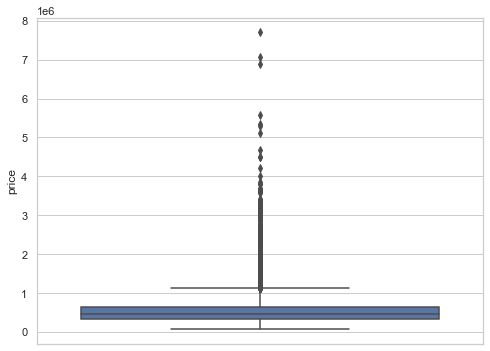

In [232]:
plt.figure(figsize=(8,6))
sns.boxplot(y=house_df['price'],showfliers=True).set_title
plt.show()

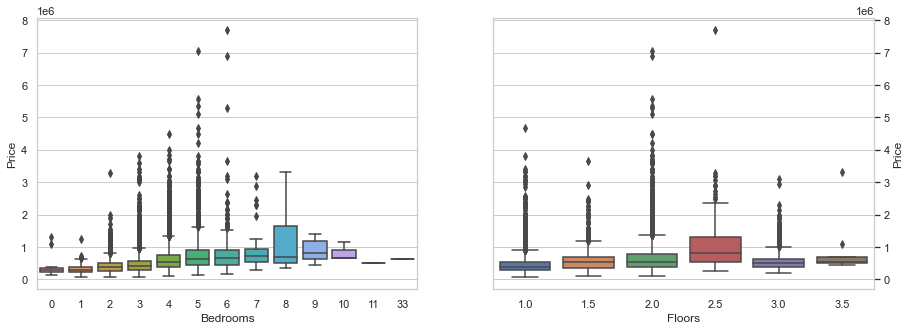

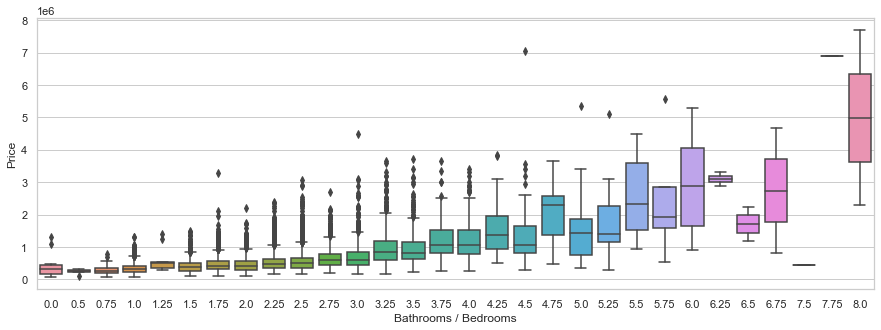

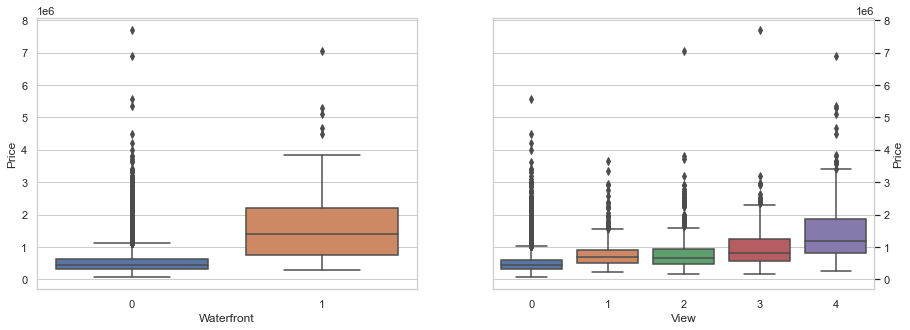

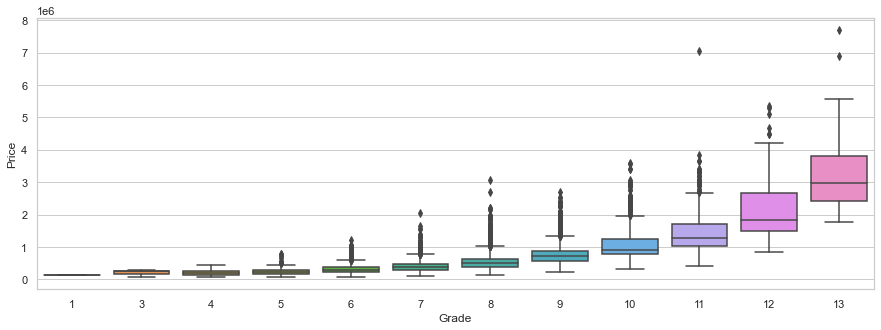

In [233]:
# Boxplots of the data features
sns.set(style="whitegrid", font_scale=1)

f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=house_df['bedrooms'],y=house_df['price'], ax=axes[0])
sns.boxplot(x=house_df['floors'],y=house_df['price'], ax=axes[1])
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(15,5))
sns.boxplot(x=house_df['bathrooms'],y=house_df['price'], ax=axe)
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price');

f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=house_df['waterfront'],y=house_df['price'], ax=axes[0])
sns.boxplot(x=house_df['view'],y=house_df['price'], ax=axes[1])
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(15,5))
sns.boxplot(x=house_df['grade'],y=house_df['price'], ax=axe)
axe.set(xlabel='Grade', ylabel='Price');

Most of the boxplots displayed above show possible outliers. While some boxplots do this accurately (there’s a house with 33 bedrooms!), others report “outliers” that make rather logical sense (houses renovated in the year 2000 or a house having a condition rating of 1).

Lower outliers 0
Upper outliers 1146
total outliers 1146
1129575.0 -162625.0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


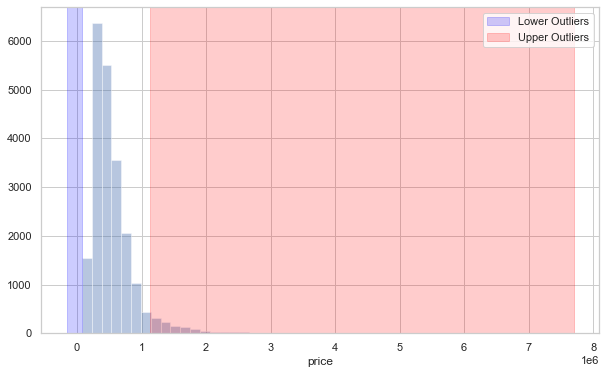

In [234]:
def calc_interquartile(data, column):
    global lower, upper
    #calculating the first and third quartile
    first_quartile, third_quartile = np.percentile(data[column], 25), np.percentile(data[column], 75)
    #calculate the interquartilerange
    iqr = third_quartile - first_quartile
    # outlier cutoff (1.5 is a generally taken as a threshold thats why i am also taking it)
    cutoff = iqr*1.5
    #calculate the lower and upper limits
    lower, upper = first_quartile - cutoff , third_quartile + cutoff
    #remove the outliers from the columns
    upper_outliers = data[data[column] > upper]
    lower_outliers = data[data[column] < lower]
    print('Lower outliers', lower_outliers.shape[0])
    print('Upper outliers', upper_outliers.shape[0])
    return print('total outliers', upper_outliers.shape[0] + lower_outliers.shape[0])
calc_interquartile(house_df, 'price')
plt.figure(figsize = (10,6))
sns.distplot(house_df['price'], kde=False)
print(upper, lower)
plt.axvspan(xmin = lower,xmax= house_df['price'].min(),alpha=0.2, color='blue', label='Lower Outliers')
plt.axvspan(xmin = upper,xmax= house_df['price'].max(),alpha=0.2, color='red', label='Upper Outliers')
plt.legend()
plt.show()

In [235]:
#removing the outliers using interquartile method
upper_outliers = house_df[house_df['price'] > upper]
upper_outliers

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
21,2524049179,2014-08-26,2000000.0,3,2.75,3050,44867,1.0,0,4,...,9,2330,720,1968,0,98040,47.5316,-122.233,4110,20336
49,822039084,2015-03-11,1350000.0,3,2.50,2753,65005,1.0,1,2,...,9,2165,588,1953,0,98070,47.4041,-122.451,2680,72513
69,1802000060,2014-06-12,1325000.0,5,2.25,3200,20158,1.0,0,0,...,8,1600,1600,1965,0,98004,47.6303,-122.215,3390,20158
125,4389200955,2015-03-02,1450000.0,4,2.75,2750,17789,1.5,0,0,...,8,1980,770,1914,1992,98004,47.6141,-122.212,3060,11275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21568,524059330,2015-01-30,1700000.0,4,3.50,3830,8963,2.0,0,0,...,10,3120,710,2014,0,98004,47.5990,-122.197,2190,10777
21576,9253900271,2015-01-07,3567000.0,5,4.50,4850,10584,2.0,1,4,...,10,3540,1310,2007,0,98008,47.5943,-122.110,3470,18270
21590,7430200100,2014-05-14,1222500.0,4,3.50,4910,9444,1.5,0,0,...,11,3110,1800,2007,0,98074,47.6502,-122.066,4560,11063
21597,191100405,2015-04-21,1575000.0,4,3.25,3410,10125,2.0,0,0,...,10,3410,0,2007,0,98040,47.5653,-122.223,2290,10125


In [236]:
#Dataset after removing outliers
house_df = house_df.drop(house_df[house_df['price']>upper].index)
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [237]:
house_df.describe(include = 'all')

<ipython-input-237-e946604f2b2b>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  house_df.describe(include = 'all')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.046700e+04,20467,2.046700e+04,20467.000000,20467.000000,20467.000000,2.046700e+04,20467.000000,20467.000000,20467.000000,...,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000,20467.000000
unique,NaN,371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-06-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2014-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-05-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.603223e+09,NaN,4.769846e+05,3.329750,2.051632,1975.558167,1.461041e+04,1.476035,0.002980,0.172668,...,7.530561,1708.330972,267.227195,1970.811013,74.681145,98078.555773,47.556888,-122.213265,1922.255191,12447.084526
std,2.877364e+09,NaN,2.083713e+05,0.912885,0.711906,774.833460,4.010956e+04,0.537033,0.054513,0.640950,...,1.039192,727.296461,409.031661,29.160540,378.761647,53.336953,0.141038,0.142412,614.932010,26538.592250
min,1.000102e+06,NaN,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.131701e+09,NaN,3.150000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,...,7.000000,1170.000000,0.000000,1951.000000,0.000000,98033.000000,47.460400,-122.330000,1470.000000,5046.000000


### Investigating other problems

In [238]:
house_df.groupby(by = 'yr_renovated')['yr_renovated'].count().sort_values(ascending = False).head()

yr_renovated
0       19701
2014       82
2013       34
2000       30
2007       29
Name: yr_renovated, dtype: int64

In [239]:
house_df['bedrooms'].value_counts()

3     9597
4     6308
2     2736
5     1339
6      230
1      198
7       30
0       12
8        9
9        4
10       2
11       1
33       1
Name: bedrooms, dtype: int64

The house with 33 bedrooms is worth exploring further.

In [240]:
house_df[house_df['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


With 1.75 bathrooms, a sale price of $640,000 it is likely that this house has 3 bedrooms and the 33 was a data entry error.

In [241]:
# Fix typo for bedrooms
house_df.loc[15870, 'bedrooms'] = 3

In [242]:
house_df['waterfront'].value_counts()

0    20406
1       61
Name: waterfront, dtype: int64

In [243]:
house_df['yr_renovated'].value_counts()

0       19701
2014       82
2013       34
2000       30
2007       29
        ...  
1956        1
1948        1
1944        1
1934        1
1954        1
Name: yr_renovated, Length: 70, dtype: int64

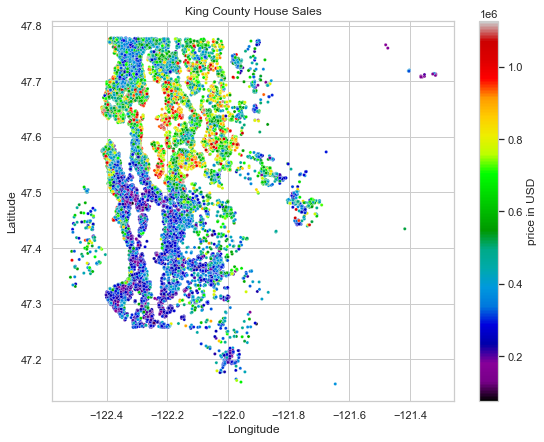

In [244]:
# Plot scatter plot
plt.figure(figsize = (9,7))
ax = sns.scatterplot(x = house_df['long'], y = house_df['lat'], hue = house_df['price'],
                palette = 'nipy_spectral',s=10, legend = None, data = house_df)

norm = plt.Normalize(house_df['price'].min(), house_df['price'].max())
smap = plt.cm.ScalarMappable(cmap='nipy_spectral', norm=norm)
smap.set_array([])

ax.figure.colorbar(smap, label = 'price in USD')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('King County House Sales')
plt.show()

In [245]:
house_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# General Observations of House Features

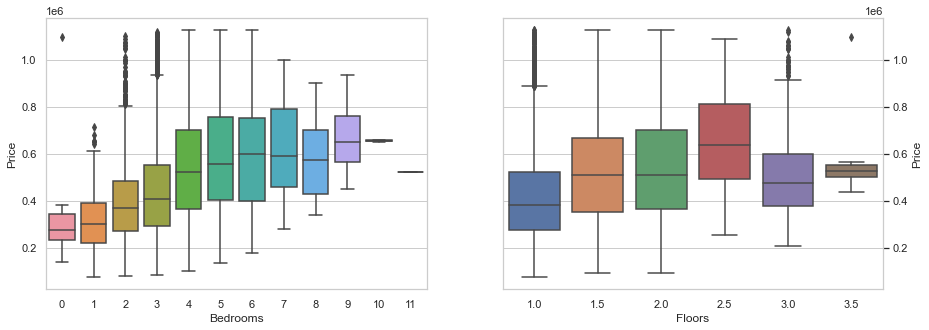

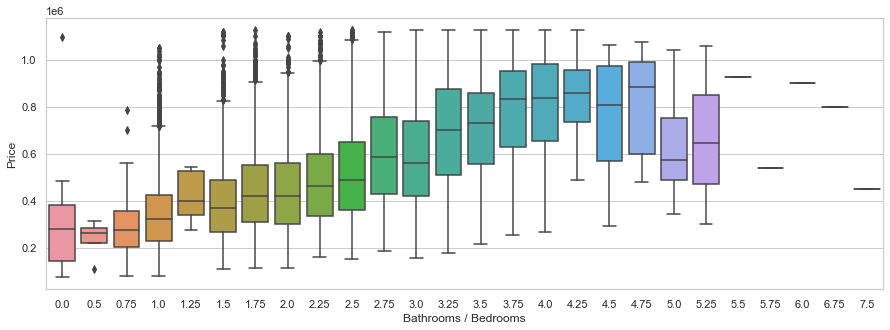

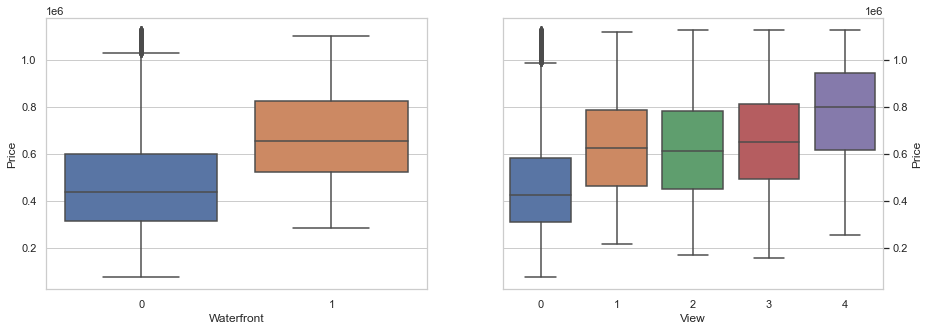

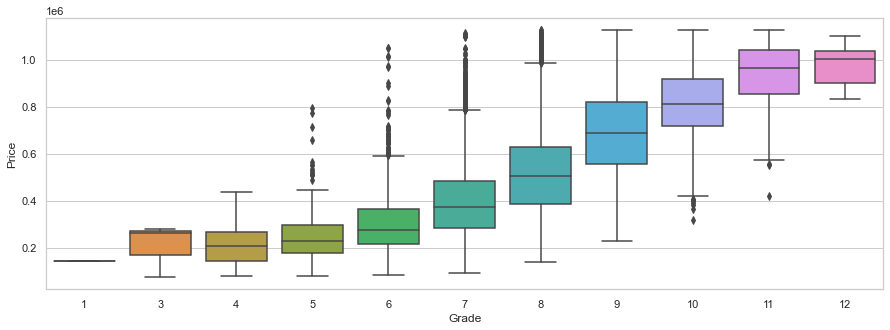

In [246]:
# Boxplots of the data features
sns.set(style="whitegrid", font_scale=1)

f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=house_df['bedrooms'],y=house_df['price'], ax=axes[0])
sns.boxplot(x=house_df['floors'],y=house_df['price'], ax=axes[1])
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(15,5))
sns.boxplot(x=house_df['bathrooms'],y=house_df['price'], ax=axe)
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price');

f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=house_df['waterfront'],y=house_df['price'], ax=axes[0])
sns.boxplot(x=house_df['view'],y=house_df['price'], ax=axes[1])
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(15,5))
sns.boxplot(x=house_df['grade'],y=house_df['price'], ax=axe)
axe.set(xlabel='Grade', ylabel='Price');

From these visualisations:

* it is immediately apparent that as bedrooms and bathrooms increase, so does the house's selling price
* more floors is preferable up to 2.5 (pressumably the 0.5 is due to a mezzanine) however a house with 3 floors has a lower median price.
* grade looks to be a good predictor of price and worth exploring further
* year_built appears to be a poor indicator of price
* a house which was renovated post 1990 will on average be valued $200,000 more.

### Investigate multicollinearity

We will investigate which of our features are correlated by plotting a heatmap with Pearson correlation coefficient.

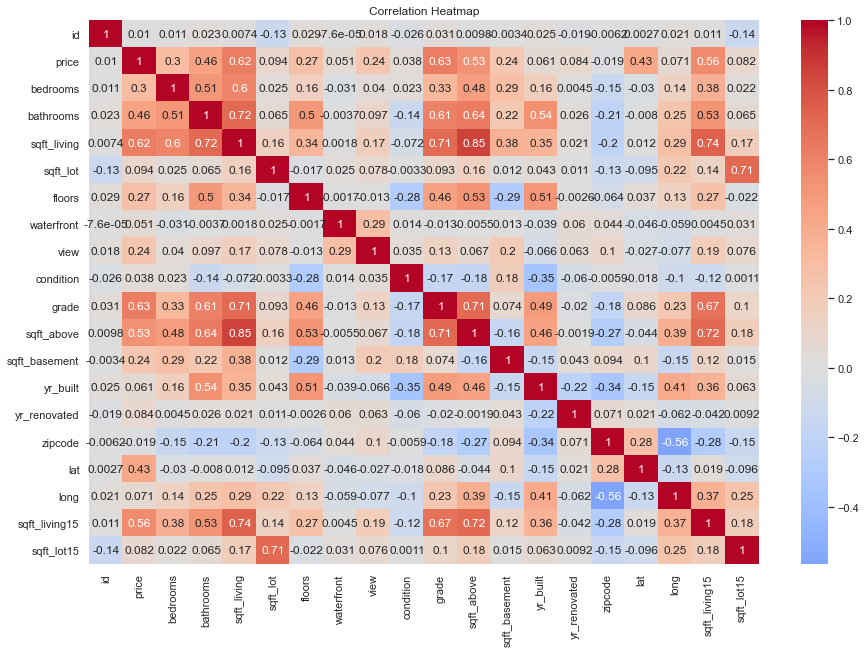

In [247]:
# Correlation matrix
corr = house_df.corr()

# Plot heatmap
plt.figure(figsize = (15,10))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

As expected there are some multicollinearity issues which we need to address.

We note that sqft_above and sqft_living are highly positively correlated, which is expected as sqft_above is the square footage of the house apart from basement (and we saw earlier that most houses did not have a basement). We will choose to keep sqft_living as it encompasses more information and drop the sqt_above feature. We also see that sqft_living15 is moderately highly correlated with sqft_living and so we will drop this feature too.

We also note that sqft_lot and sqft_lot15 are highly positively correlated and we will choose to keep sqft_lot as it relates directly to the house as opposed to its neighbours (and so potentially easier to obtain data for and generalise.)

In [248]:
house_df = house_df.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis = 1)
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069


In [249]:
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069


### Data Transformations

In this part, I checked the distributions for the features. 
It’s generally a good idea to transform these variables to resemble normal distributions.

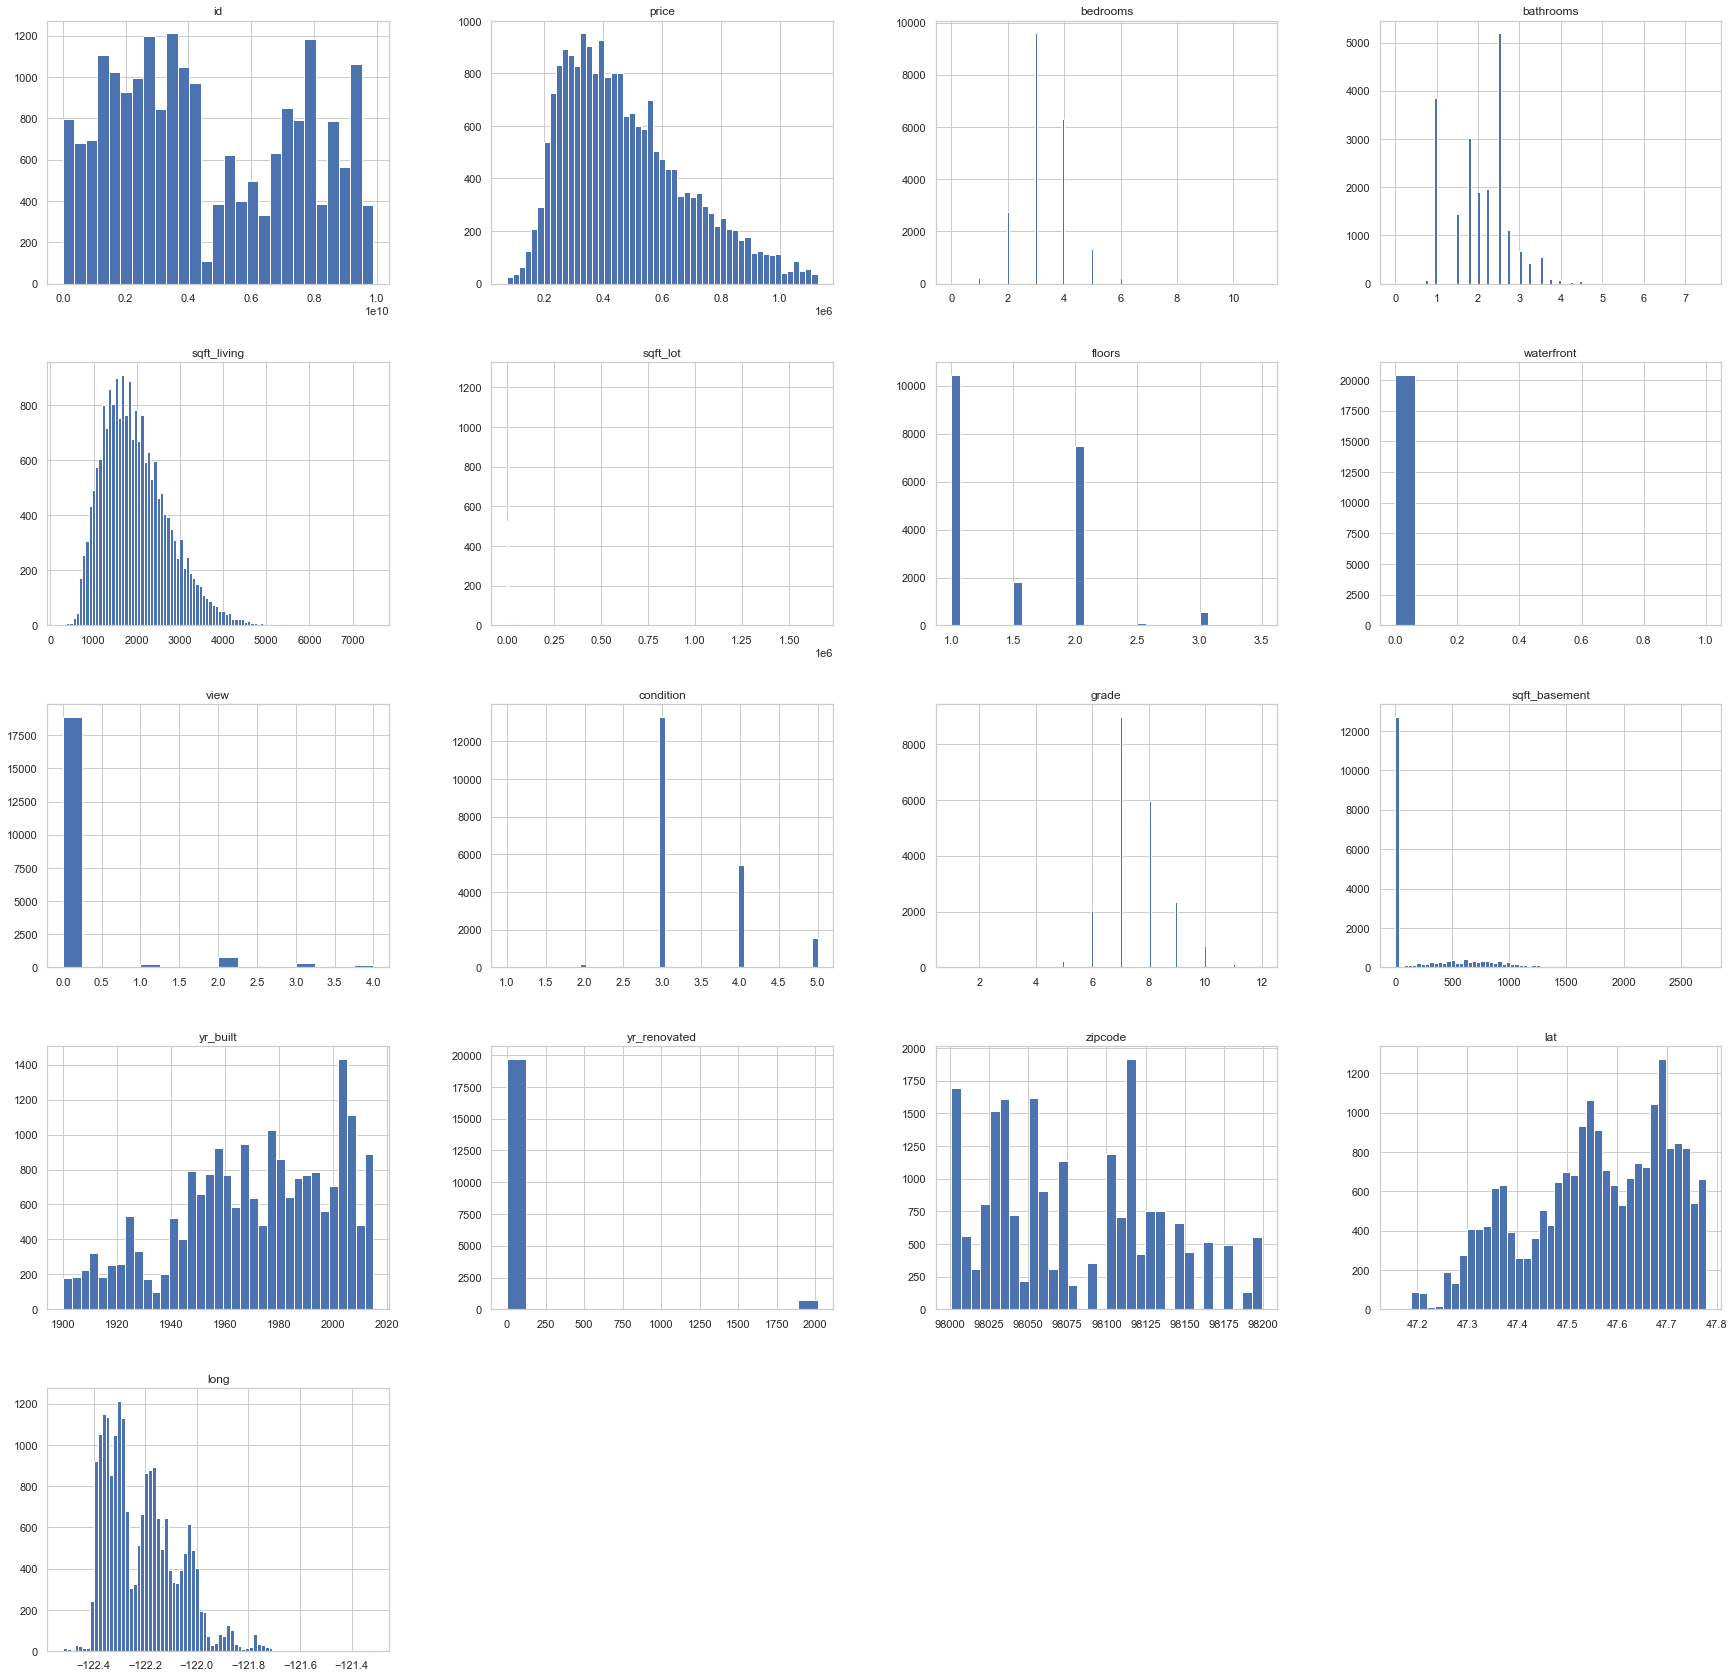

In [250]:
histo = house_df.hist(bins = 'auto' ,figsize= (30,30))

In [251]:
log_vars = ["log_sqft_living", "log_sqft_lot"]
# log-transforming chosen variables
house_df[log_vars] = np.log(house_df[["sqft_living", "sqft_lot"]])
# dropping un-transformed variables
house_df.drop(["sqft_living", "sqft_lot"], axis = 1, inplace = True)

As seen by the output above, the distributions of our predictor variables have now changed to resemble more of a normal distribution (symmetrical, unimodal, “bell-shaped”). This is good news as it’ll help our model performance later on.

We have now cleaned the data of all missing values, checked for duplicates, handled extreme values (outliers), and converted each column to its correct data type.

# Feature Engineering

In our DataFrame we have the following features relating to location: lat, long and zipcode. We think it might be worthwhile exploring reverse geocoding to obtain an address based on latitude and longitude.

I will focus to create a column with the Neighbourhood of each observation. Let us now focus on zipcode information, which was provided as part of our starting data.

### 1. Adding Neighbourhood Feature

In [252]:
house_df

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,7.073270,8.639411
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,7.851661,8.887653
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,6.646391,9.210340
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,7.580700,8.517193
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,7.426549,8.997147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,7.333023,7.030857
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,7.745003,8.667852
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,6.927558,7.207860
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,7.377759,7.778211


In [253]:
house_df_w_fe = house_df.copy()

In [254]:
house_df_w_fe

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,7.073270,8.639411
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,7.851661,8.887653
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,6.646391,9.210340
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,7.580700,8.517193
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,7.426549,8.997147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,7.333023,7.030857
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,7.745003,8.667852
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,6.927558,7.207860
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,7.377759,7.778211


In [255]:
# Explore zipcode
house_df_w_fe['zipcode'].value_counts()

98103    590
98038    588
98052    563
98115    558
98042    548
        ... 
98102     89
98109     86
98024     74
98148     57
98039      6
Name: zipcode, Length: 70, dtype: int64

We see that there are 70 unique zipcodes represented in our dataset.

Let us create a heatmap to explore the median house price per zipcode and see if we can establish zipcode 'tiers'. We will make use of a geojson file showing the zip code boundaries and extract price and zipcode data from our dataset.

The geojson file was found on the King County GIS website.

https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/api



In [256]:
# Load geojson file
geodatafilename = 'Zipcodes_for_King_County.json'
gdf = gpd.read_file(geodatafilename)
gdf.head()

,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAME,PREFERRED_CITY,Shape_Length,Shape_Area,geometry
0,1,98001,98001,033,Standard,King County,AUBURN,148134.771476,5.261214e+08,"POLYGON ((-122.22992 47.35377, -122.22993 47.3..."
1,2,98002,98002,033,Standard,King County,AUBURN,105168.476823,2.044452e+08,"POLYGON ((-122.22921 47.35375, -122.22915 47.3..."
2,3,98003,98003,033,Standard,King County,FEDERAL WAY,121645.069928,3.169812e+08,"POLYGON ((-122.30940 47.35795, -122.30940 47.3..."
3,4,98004,98004,033,Standard,King County,BELLEVUE,108801.063326,2.014512e+08,"MULTIPOLYGON (((-122.21458 47.65298, -122.2146..."
4,5,98005,98005,033,Standard,King County,BELLEVUE,116930.354131,2.112733e+08,"POLYGON ((-122.15876 47.66065, -122.15839 47.6..."


In [257]:
gdf.dtypes

OBJECTID             int64
ZIP                  int64
ZIPCODE             object
COUNTY              object
ZIP_TYPE            object
COUNTY_NAME         object
PREFERRED_CITY      object
Shape_Length       float64
Shape_Area         float64
geometry          geometry
dtype: object

In [258]:
#bing_api_key = "Deleted for security purposes"
house_df_w_fe['coord'] = list(zip(house_df_w_fe['lat'], house_df_w_fe['long']))

In [259]:
house_df_w_fe['coord']

0                   (47.5112, -122.257)
1        (47.721000000000004, -122.319)
2        (47.7379, -122.23299999999999)
3        (47.5208, -122.39299999999999)
4                   (47.6168, -122.045)
                      ...              
21608               (47.6993, -122.346)
21609    (47.5107, -122.36200000000001)
21610    (47.5944, -122.29899999999999)
21611               (47.5345, -122.069)
21612    (47.5941, -122.29899999999999)
Name: coord, Length: 20467, dtype: object

The code below was used to obtain addresses using Bing. It has been commented out to not call the API unecessarily each time we run cells.



In [260]:
# Create an empty list to store addresses
#import time
#addresses = []

# Call API with key
#geolocator = Bing(api_key=bing_api_key, timeout=60)

# Add delay
#reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)
#count = 0
# # Iterate over coordinates and add addresses to list
#for coordinates in house_df_w_fe['coord']:
#    print(count , end=" ")
#    loc = geolocator.reverse(coordinates, exactly_one = True, include_country_code=False)
#    time.sleep(0.1)
#    addresses.append(loc)
#    count += 1

In [261]:
#Save addresses
#with open('addresses.pkl', 'wb') as f:
#    pickle.dump(addresses, f)

In [262]:
# Load addresses
with open('addresses.pkl', 'rb') as f:
    address = pickle.load(f)

In [263]:
address[:10]

[Location(10012 61st Ave S, Rainier Valley, WA 98178, United States, (47.511233, -122.256727, 0.0)),
 Location(837 NE 127th St, Northgate, WA 98125, United States, (47.721023, -122.319115, 0.0)),
 Location(15109 81st Ave NE, Kenmore, WA 98028, United States, (47.737924, -122.233197, 0.0)),
 Location(9236 Fauntleroy Way SW, West Seattle, WA 98136, United States, (47.520808, -122.393159, 0.0)),
 Location(901 221st Ave NE, Sammamish, WA 98074, United States, (47.61681, -122.044902, 0.0)),
 Location(533 S 330th Pl, West Campus-Fed Way, WA 98003, United States, (47.309706, -122.327101, 0.0)),
 Location(21421 14th Ave S, Central Des Moines, WA 98198, United States, (47.409511, -122.31519, 0.0)),
 Location(216 SW 102nd St, Highline, WA 98146, United States, (47.512349, -122.337237, 0.0)),
 Location(26007 232nd Pl SE, Wilderness Village, WA 98038, United States, (47.368404, -122.030821, 0.0)),
 Location(1017 146th Ave SE, Lake Hills, WA 98007, United States, (47.600695, -122.144782, 0.0))]

In [264]:
# Get results from reverse_geocoder
results = rg.search(list(house_df_w_fe['coord']))

In [265]:
# View first entry
results[0]

{'lat': '47.4943',
 'lon': '-122.24092',
 'name': 'Bryn Mawr-Skyway',
 'admin1': 'Washington',
 'admin2': 'King County',
 'cc': 'US'}

We note that results returns a list of dictionaries. We are interested in the value of the key name. Let us extract these by creating a new list called neighbourhoods.

In [266]:
# Get list of neighbourhoods
neighbourhoods = [results[i]['name'] for i in range(0, len(results))] 
neighbourhoods[:5]

['Bryn Mawr-Skyway',
 'Shoreline',
 'Inglewood-Finn Hill',
 'White Center',
 'City of Sammamish']


Now that we see how we can obtain neighbourhoods, let us create a function to retrieve neighbourhood using reverse_geocoder and add the feature. We might wish to add this feature to our main training dataset and if so will also need it for our test dataset.

In [267]:
# Define function to add neighbourhood
def neighbourhood_feat(df):
    '''Adds neighbourhood feature using reverse_geocoder'''
    
    # Define coord column with lat and long
    df['coord'] = list(zip(df['lat'], df['long']))
    
    # Use reverse geocoder
    results = rg.search(list(df['coord']))
    
    # Define neighbourhood list
    neighbourhoods = [results[i]['name'] for i in range(0, len(results))]
    
    # Add neighbourhood feature
    df['neighbourhood'] = neighbourhoods
    
    return df

In [268]:
df = house_df_w_fe
df

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot,coord
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,7.073270,8.639411,"(47.5112, -122.257)"
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,7.851661,8.887653,"(47.721000000000004, -122.319)"
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,6.646391,9.210340,"(47.7379, -122.23299999999999)"
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,7.580700,8.517193,"(47.5208, -122.39299999999999)"
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,7.426549,8.997147,"(47.6168, -122.045)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,7.333023,7.030857,"(47.6993, -122.346)"
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,7.745003,8.667852,"(47.5107, -122.36200000000001)"
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,6.927558,7.207860,"(47.5944, -122.29899999999999)"
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,7.377759,7.778211,"(47.5345, -122.069)"


In [269]:
house_df

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,7.073270,8.639411
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,7.851661,8.887653
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,6.646391,9.210340
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,7.580700,8.517193
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,7.426549,8.997147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,7.333023,7.030857
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,7.745003,8.667852
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,6.927558,7.207860
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,7.377759,7.778211


In [270]:
# Create new feature
house_df_w_fe = neighbourhood_feat(house_df_w_fe)

# See neighbourhoods with most sales
house_df_w_fe['neighbourhood'].value_counts()[:5]

Seattle              2532
Shoreline            1779
White Center         1366
Lake Forest Park      615
City of Sammamish     595
Name: neighbourhood, dtype: int64

In [271]:
# Groupby zipcode and take median price
house_df_w_fe = house_df_w_fe.groupby(house_df_w_fe['neighbourhood'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
house_df_w_fe = house_df_w_fe.reset_index()

house_df_w_fe.head()

,neighbourhood,price
0,Medina,928750.0
1,Clyde Hill,847500.0
2,Bellevue,775000.0
3,Ames Lake,734000.0
4,Yarrow Point,716500.0


These neighbourhoods have the highest median house price.

In [272]:
house_df_w_fe.tail()

,neighbourhood,price
74,SeaTac,254500.0
75,Tacoma,236775.0
76,Algona,230000.0
77,Auburn,229950.0
78,Gold Bar,168500.0


These neighbourhoods have the lowest median house price.

### 2. Adding Month_Sale and Quarter_Sale Features

In this section, we will explore the best time of the year to sell.

Our first step will be to engineer new features, namely sale_month and sale_quarter.

In [273]:
# Define function to create sale_month feature
def Month_Sale_feature(df):
    '''Creates sale_month feature using date feature'''
    df['Month_Sale'] = pd.DatetimeIndex(df['date']).month
    return df

# Define function to determine quarter
def quarter(month):
    ''' Returns quarter in which month falls'''
    if 1 <= month <= 3:
        quarter = 'Q1'
    elif 4 <= month <= 6:
        quarter = 'Q2'
    elif 7 <= month <= 9:
        quarter = 'Q3'
    else:
        quarter = 'Q4'
    return quarter

# Define function to create sale_quarter feature
def Quarter_Sale_feature(df):
    ''' Creates quarter_sold feature using quarter function'''
    df['Quarter_Sale'] = df['Month_Sale'].apply(quarter)
    return df

In [274]:
house_df

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,7.073270,8.639411
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,7.851661,8.887653
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,6.646391,9.210340
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,7.580700,8.517193
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,7.426549,8.997147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,7.333023,7.030857
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,7.745003,8.667852
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,6.927558,7.207860
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,7.377759,7.778211


In [275]:
house_df_w_fe

,neighbourhood,price
0,Medina,928750.0
1,Clyde Hill,847500.0
2,Bellevue,775000.0
3,Ames Lake,734000.0
4,Yarrow Point,716500.0
...,...,...
74,SeaTac,254500.0
75,Tacoma,236775.0
76,Algona,230000.0
77,Auburn,229950.0


In [276]:
house_df_final = house_df

house_df_final = Month_Sale_feature(house_df)

house_df_final = Quarter_Sale_feature(house_df)

In [277]:
house_df_final

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot,Month_Sale,Quarter_Sale
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,7.073270,8.639411,10,Q4
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,7.851661,8.887653,12,Q4
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,6.646391,9.210340,2,Q1
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,7.580700,8.517193,12,Q4
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,7.426549,8.997147,2,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,7.333023,7.030857,5,Q2
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,7.745003,8.667852,2,Q1
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,6.927558,7.207860,6,Q2
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,7.377759,7.778211,1,Q1


### Visualization Of Sales

We will look to undestand whether time of year influences

* The sale price, i.e. whether there are any patterns resulting in higher prices for a certain time of the year
* Frequency of sales, i.e. whether there is a particular time of the year that results in increased volume of sales

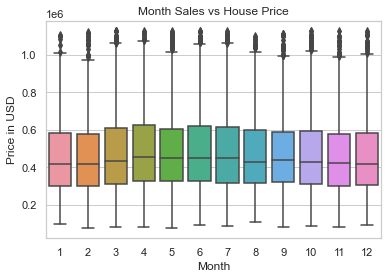

In [278]:
# Plot boxplot of monthly Sales vs price
sns.boxplot(x = house_df_final['Month_Sale'], y = house_df_final['price'], data = house_df_final)
plt.xlabel('Month')
plt.ylabel('Price in USD')
plt.title('Month Sales vs House Price')
plt.show()

There is no apparent pattern here. The median house price does not appear to be affected by the sale month.

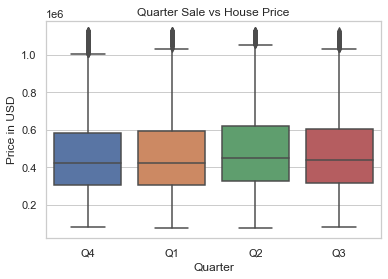

In [279]:
# Plot boxplot of quarterly Sales vs price
sns.boxplot(x = house_df_final['Quarter_Sale'], y = house_df_final['price'], data = house_df_final)
plt.xlabel('Quarter')
plt.ylabel('Price in USD')
plt.title('Quarter Sale vs House Price')
plt.show()

We would imagine that sale quarter has little to no impact on sale price.

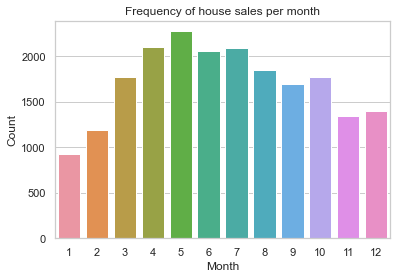

In [280]:
# Countplot of sale_month
sns.countplot(x = house_df_final['Month_Sale'], data = house_df_final)
plt.title('Frequency of house sales per month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

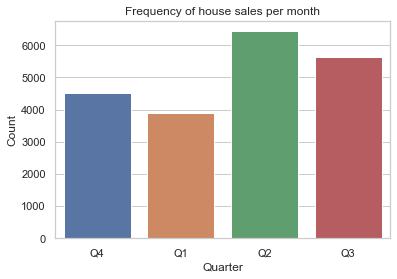

In [281]:
# Countplot of sale_quarter
sns.countplot(x = house_df_final['Quarter_Sale'], data = house_df_final)
plt.title('Frequency of house sales per month')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.show()

The `Month_Sale` feature and visualisation above demonstrate that April and May are the most popular months for house sales. In contrast, January and February have the lowest number of sales.

# Preparing Data For Modeling

In [311]:
house_df = house_df_final.copy()

#Adding neighbourhood feature
house_df = neighbourhood_feat(house_df)
house_df

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,log_sqft_living,log_sqft_lot,Month_Sale,Quarter_Sale,coord,neighbourhood
0,7129300520,2014-10-13,221900.0,3,1.00,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,7.073270,8.639411,10,Q4,"(47.5112, -122.257)",Bryn Mawr-Skyway
1,6414100192,2014-12-09,538000.0,3,2.25,2.0,0,0,3,7,...,1991,98125,47.7210,-122.319,7.851661,8.887653,12,Q4,"(47.721000000000004, -122.319)",Shoreline
2,5631500400,2015-02-25,180000.0,2,1.00,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,6.646391,9.210340,2,Q1,"(47.7379, -122.23299999999999)",Inglewood-Finn Hill
3,2487200875,2014-12-09,604000.0,4,3.00,1.0,0,0,5,7,...,0,98136,47.5208,-122.393,7.580700,8.517193,12,Q4,"(47.5208, -122.39299999999999)",White Center
4,1954400510,2015-02-18,510000.0,3,2.00,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,7.426549,8.997147,2,Q1,"(47.6168, -122.045)",City of Sammamish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,3.0,0,0,3,8,...,0,98103,47.6993,-122.346,7.333023,7.030857,5,Q2,"(47.6993, -122.346)",Shoreline
21609,6600060120,2015-02-23,400000.0,4,2.50,2.0,0,0,3,8,...,0,98146,47.5107,-122.362,7.745003,8.667852,2,Q1,"(47.5107, -122.36200000000001)",White Center
21610,1523300141,2014-06-23,402101.0,2,0.75,2.0,0,0,3,7,...,0,98144,47.5944,-122.299,6.927558,7.207860,6,Q2,"(47.5944, -122.29899999999999)",Seattle
21611,291310100,2015-01-16,400000.0,3,2.50,2.0,0,0,3,8,...,0,98027,47.5345,-122.069,7.377759,7.778211,1,Q1,"(47.5345, -122.069)",Issaquah


### Model 1

This model will be generalisable. We will aim where possible to ensure it can be used as a basis towards creating a model for another area, so avoid features engineering . Provided we achieve a decent $R^2$, we will try and avoid interactions and/or polynomial regression.

In [312]:
#Split Features X and target y + Removing irrelevant features
X = house_df.drop(['price','id' , 'date' , 'lat' , 'long' , 'coord', 'Month_Sale', 'Quarter_Sale',
                   'neighbourhood','zipcode'] , axis = 1)
y = house_df['price']
X

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,log_sqft_living,log_sqft_lot
0,3,1.00,1.0,0,0,3,7,0,1955,0,7.073270,8.639411
1,3,2.25,2.0,0,0,3,7,400,1951,1991,7.851661,8.887653
2,2,1.00,1.0,0,0,3,6,0,1933,0,6.646391,9.210340
3,4,3.00,1.0,0,0,5,7,910,1965,0,7.580700,8.517193
4,3,2.00,1.0,0,0,3,8,0,1987,0,7.426549,8.997147
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,3.0,0,0,3,8,0,2009,0,7.333023,7.030857
21609,4,2.50,2.0,0,0,3,8,0,2014,0,7.745003,8.667852
21610,2,0.75,2.0,0,0,3,7,0,2009,0,6.927558,7.207860
21611,3,2.50,2.0,0,0,3,8,0,2004,0,7.377759,7.778211


In [313]:
#Split data into training-validation-testing
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42) 

# 0.25 x 0.8 = 0.2
#training = 0.6 
#validation = 0.2
#testing = 0.2

In [314]:
#Identify Numerical and Categorical Features
numeric_features = []
categorical_features = []

for column in X.columns:
    if X[column].dtypes==int or X[column].dtypes==float:
        numeric_features.append(column)
    else:
        categorical_features.append(column)
print("Numeracal Features are: " , numeric_features)
print("\nCategorical Features are : " , categorical_features)


#No Categorical Features

Numeracal Features are:  ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'log_sqft_living', 'log_sqft_lot']

Categorical Features are :  []


In [315]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_val)
lr.score(X_val,y_val)

0.5702817837987295

In [316]:
# training and hyper-parameter tuning of DecisionTree

dt = DecisionTreeRegressor()

param_dict = {
    'max_depth':range(2,18),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(2,5)}

grid = GridSearchCV(dt,param_grid=param_dict,cv=5 ,
                    verbose = 1 , n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:   32.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 18),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [317]:
grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 6}

In [321]:
# training and hyper-parameter tuning of Random Forest

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 10, 15, 18]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [2, 5, 10]
rf = RandomForestRegressor(DecisionTreeRegressor(max_depth= 8, min_samples_leaf= 2, min_samples_split= 3))
hyper_rf = dict(n_estimators = n_estimators, max_depth = max_depth, 
              min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
gridrf = GridSearchCV(rf, hyper_rf, cv = 3, verbose = 1, n_jobs = -1)
bestrf = gridrf.fit(X_train,y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 70.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 76.7min finished


In [322]:
gridrf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 800}

In [328]:
# training and hyper-parameter tuning of bagging
#Setting values for the parameters
n_estimators = [30, 50 , 100, 300, 500, 800, 1200]
max_samples = [5, 10, 25, 50, 100,300,500,700]
max_features = [2, 5, 10, 13,17]
bagg = BaggingRegressor(DecisionTreeRegressor(max_depth= 8, min_samples_leaf= 2, min_samples_split= 3))
hyperbag = dict(n_estimators = n_estimators, max_samples = max_samples, 
              max_features = max_features)

gridbag = GridSearchCV(bagg, hyperbag, cv = 3,
                       verbose = 1, n_jobs = -1)
gridbag.fit(X_train,y_train)

Fitting 3 folds for each of 280 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  3.0min finished


GridSearchCV(cv=3,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8,
                                                                             min_samples_leaf=2,
                                                                             min_samples_split=3)),
             n_jobs=-1,
             param_grid={'max_features': [2, 5, 10, 13, 17],
                         'max_samples': [5, 10, 25, 50, 100, 300, 500, 700],
                         'n_estimators': [30, 50, 100, 300, 500, 800, 1200]},
             verbose=1)

In [329]:
gridbag.best_params_

{'max_features': 10, 'max_samples': 700, 'n_estimators': 800}

In [330]:
# training and hyper-parameter tuning of AdaBoost
#Setting values for the parameters
n_estimators = [100, 300, 500, 800, 1200]
learning_rate = [0.01,0.05,0.1,0.5]
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth= 8, min_samples_leaf= 2, min_samples_split= 3))
hyperbag = dict(n_estimators = n_estimators, learning_rate = learning_rate)
gridbag = GridSearchCV(ada, hyperbag, cv = 3,
                       verbose = 1, n_jobs = -1)
gridbag.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.0min finished


GridSearchCV(cv=3,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8,
                                                                              min_samples_leaf=2,
                                                                              min_samples_split=3)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             verbose=1)

In [331]:
gridbag.best_params_

{'learning_rate': 0.01, 'n_estimators': 500}

In [332]:
#GradientBoosting Regressor
estimator = GradientBoostingRegressor()
param_grid = dict()
param_grid['n_estimators'] = [100, 300, 500, 800, 1200]
param_grid['learning_rate']= [0.01,0.05,0.1,0.5]
param_grid['max_depth'] = [2,3,4,5]

grid = GridSearchCV(estimator = estimator , param_grid = param_grid ,cv =5 , verbose = 1 , n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 15.0min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             verbose=1)

In [333]:
grid.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1200}

In [339]:
#Evaluation of all models after being tuned

evaluationtable = pd.DataFrame({'Regressor':[],'Validation Score':[]
                                ,'R-squared':[],
                                'MSE':[],
                                'RMSE': []})
Regressor_list = ['Linear Regression' , 'Decision Tree' ,
                 'Random Forest', 'Bagging Regressor' , 'Gradient Boosting' ,'Ada Boost']
i = 0
Regressors = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth = 7 , min_samples_leaf = 3 , min_samples_split = 6),
    RandomForestRegressor(max_depth = 15 , min_samples_leaf = 2 , min_samples_split = 15 , n_estimators = 800),
    BaggingRegressor(DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 3, min_samples_split= 6), max_features = 10 , max_samples = 700 , n_estimators = 800 ),
    GradientBoostingRegressor(learning_rate = 0.01 , max_depth = 5 , n_estimators = 1200),
    AdaBoostRegressor(DecisionTreeRegressor(max_depth= 8, min_samples_leaf= 3, min_samples_split= 6) , learning_rate = 0.01 , n_estimators = 500)    
]                          
for Regressor in Regressors:
    pipe = Pipeline(steps=[('Regressor', Regressor)])
    pipe.fit(X_train, y_train)
    prediction = pipe.predict(X_val)
    x1 = round(pipe.score(X_val, y_val) , 3)
    x2 = round(r2_score(prediction, y_val) , 3)
    x3 = round(mean_squared_error(prediction, y_val) , 3)
    x4 = round(np.sqrt(mean_squared_error(prediction, y_val)) , 3)
    new_row = {'Regressor':Regressor_list[i], 'Validation Score':x1, 'R-squared':x2, 'MSE':x3,'RMSE':x4}
    #append row to the dataframe
    evaluationtable = evaluationtable.append(new_row, ignore_index=True)
    i += 1
evaluationtable.set_index('Regressor' , inplace = True)
evaluationtable

,Validation Score,R-squared,MSE,RMSE
Regressor,,,,
Linear Regression,0.570,0.228,1.914773e+10,138375.330
Decision Tree,0.579,0.313,1.877341e+10,137016.088
Random Forest,0.631,0.401,1.644134e+10,128223.792
Bagging Regressor,0.609,0.189,1.743172e+10,132029.238
Gradient Boosting,0.633,0.403,1.635684e+10,127893.860
Ada Boost,0.617,0.287,1.707463e+10,130669.936


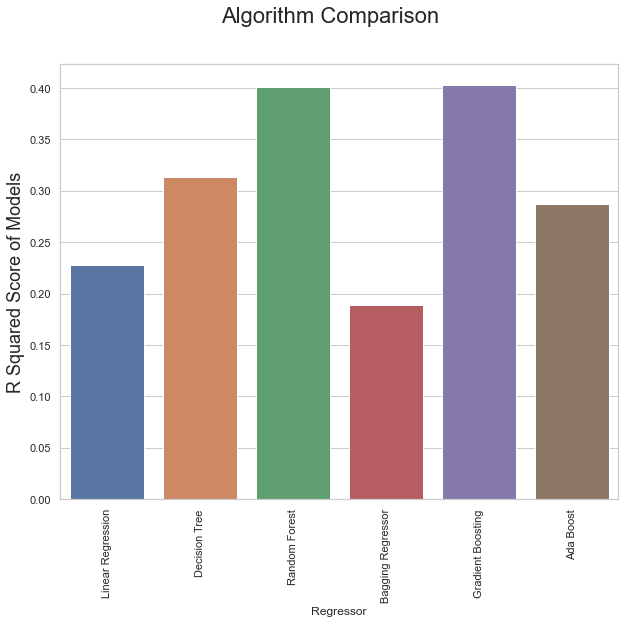

In [340]:
#Plot the performance of the model

fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.barplot(x=evaluationtable.index, y=evaluationtable['R-squared'])
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

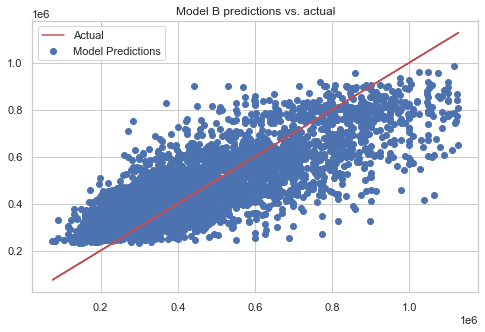

In [341]:
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_val, prediction, label='Model Predictions')
plt.plot(y_val, y_val, label='Actual', color='r')
plt.title('Model B predictions vs. actual')
plt.legend()
plt.show()

### Model 2

This model will be our most accurate and most likely complex. We will aim for the highest adjusted $R^2$ value and lowest Root Mean Squared Error (RMSE). We will also use some hyperparamater tuning and feature engineering

In [353]:
#Split Features X and target y + Removing irrelevant features
X = house_df.drop(['price','id' , 'date' , 'lat' , 'long' , 'coord', 'zipcode'] , axis = 1)
y = house_df['price']
X

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,log_sqft_living,log_sqft_lot,Month_Sale,Quarter_Sale,neighbourhood
0,3,1.00,1.0,0,0,3,7,0,1955,0,7.073270,8.639411,10,Q4,Bryn Mawr-Skyway
1,3,2.25,2.0,0,0,3,7,400,1951,1991,7.851661,8.887653,12,Q4,Shoreline
2,2,1.00,1.0,0,0,3,6,0,1933,0,6.646391,9.210340,2,Q1,Inglewood-Finn Hill
3,4,3.00,1.0,0,0,5,7,910,1965,0,7.580700,8.517193,12,Q4,White Center
4,3,2.00,1.0,0,0,3,8,0,1987,0,7.426549,8.997147,2,Q1,City of Sammamish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,3.0,0,0,3,8,0,2009,0,7.333023,7.030857,5,Q2,Shoreline
21609,4,2.50,2.0,0,0,3,8,0,2014,0,7.745003,8.667852,2,Q1,White Center
21610,2,0.75,2.0,0,0,3,7,0,2009,0,6.927558,7.207860,6,Q2,Seattle
21611,3,2.50,2.0,0,0,3,8,0,2004,0,7.377759,7.778211,1,Q1,Issaquah


In [354]:
# Define one-hot encoding function
def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [355]:
#Identify Numerical and Categorical Features
numeric_features = []
categorical_features = []

for column in X.columns:
    if X[column].dtypes==int or X[column].dtypes==float:
        numeric_features.append(column)
    else:
        categorical_features.append(column)
print("Numeracal Features are: " , numeric_features)
print("\nCategorical Features are : " , categorical_features)

Numeracal Features are:  ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'log_sqft_living', 'log_sqft_lot', 'Month_Sale']

Categorical Features are :  ['Quarter_Sale', 'neighbourhood']


In [356]:
X = one_hot_encode(X , 'Quarter_Sale')
X = one_hot_encode(X , 'neighbourhood')
X

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,...,Tacoma,Tanner,Tukwila,Union Hill-Novelty Hill,Vashon,West Lake Sammamish,White Center,Woodinville,Woodway,Yarrow Point
0,3,1.00,1.0,0,0,3,7,0,1955,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2.25,2.0,0,0,3,7,400,1951,1991,...,0,0,0,0,0,0,0,0,0,0
2,2,1.00,1.0,0,0,3,6,0,1933,0,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1.0,0,0,5,7,910,1965,0,...,0,0,0,0,0,0,1,0,0,0
4,3,2.00,1.0,0,0,3,8,0,1987,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,3.0,0,0,3,8,0,2009,0,...,0,0,0,0,0,0,0,0,0,0
21609,4,2.50,2.0,0,0,3,8,0,2014,0,...,0,0,0,0,0,0,1,0,0,0
21610,2,0.75,2.0,0,0,3,7,0,2009,0,...,0,0,0,0,0,0,0,0,0,0
21611,3,2.50,2.0,0,0,3,8,0,2004,0,...,0,0,0,0,0,0,0,0,0,0


In [357]:
#Split data into training-validation-testing
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42) 

# 0.25 x 0.8 = 0.2
#training = 0.6 
#validation = 0.2
#testing = 0.2

In [358]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_val)
lr.score(X_val,y_val)

0.7929177586375776

In [359]:
# training and hyper-parameter tuning of DecisionTree

dt = DecisionTreeRegressor()

param_dict = {
    'max_depth':range(2,18),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(2,5)}

grid = GridSearchCV(dt,param_grid=param_dict,cv=5 ,
                    verbose = 1 , n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.4min finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 18),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [360]:
grid.best_params_

{'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 9}

In [362]:
# training and hyper-parameter tuning of Random Forest

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 10, 15, 18]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [2, 5, 10]
rf = RandomForestRegressor(DecisionTreeRegressor(max_depth= 17, min_samples_leaf= 2, min_samples_split= 9))
hyper_rf = dict(n_estimators = n_estimators, max_depth = max_depth, 
              min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
gridrf = GridSearchCV(rf, hyper_rf, cv = 3, verbose = 1, n_jobs = -1)
bestrf = gridrf.fit(X_train,y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 130.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 152.3min finished


In [363]:
gridrf.best_params_

{'max_depth': 18,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 800}

In [364]:
# training and hyper-parameter tuning of bagging
#Setting values for the parameters
n_estimators = [30, 50 , 100, 300, 500, 800, 1200]
max_samples = [5, 10, 25, 50, 100,300,500,700]
max_features = [2, 5, 10, 13,17]
bagg = BaggingRegressor(DecisionTreeRegressor(max_depth= 17, min_samples_leaf= 2, min_samples_split= 9))
hyperbag = dict(n_estimators = n_estimators, max_samples = max_samples, 
              max_features = max_features)

gridbag = GridSearchCV(bagg, hyperbag, cv = 3,
                       verbose = 1, n_jobs = -1)
gridbag.fit(X_train,y_train)

Fitting 3 folds for each of 280 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  6.2min finished


GridSearchCV(cv=3,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=17,
                                                                             min_samples_leaf=2,
                                                                             min_samples_split=9)),
             n_jobs=-1,
             param_grid={'max_features': [2, 5, 10, 13, 17],
                         'max_samples': [5, 10, 25, 50, 100, 300, 500, 700],
                         'n_estimators': [30, 50, 100, 300, 500, 800, 1200]},
             verbose=1)

In [365]:
gridbag.best_params_

{'max_features': 17, 'max_samples': 500, 'n_estimators': 30}

In [366]:
# training and hyper-parameter tuning of AdaBoost
#Setting values for the parameters
n_estimators = [100, 300, 500, 800, 1200]
learning_rate = [0.01,0.05,0.1,0.5]
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth= 17, min_samples_leaf= 2, min_samples_split= 9))
hyperbag = dict(n_estimators = n_estimators, learning_rate = learning_rate)
gridbag = GridSearchCV(ada, hyperbag, cv = 3,
                       verbose = 1, n_jobs = -1)
gridbag.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.5min finished


GridSearchCV(cv=3,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=17,
                                                                              min_samples_leaf=2,
                                                                              min_samples_split=9)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             verbose=1)

In [367]:
gridbag.best_params_

{'learning_rate': 0.5, 'n_estimators': 1200}

In [368]:
#GradientBoosting Regressor
estimator = GradientBoostingRegressor()
param_grid = dict()
param_grid['n_estimators'] = [100, 300, 500, 800, 1200]
param_grid['learning_rate']= [0.01,0.05,0.1,0.5]
param_grid['max_depth'] = [2,3,4,5]

grid = GridSearchCV(estimator = estimator , param_grid = param_grid ,cv =5 , verbose = 1 , n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 29.9min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             verbose=1)

In [369]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1200}

In [374]:
#Evaluation of all models after being tuned

evaluationtable = pd.DataFrame({'Regressor':[],'Validation Score':[]
                                ,'R-squared':[],
                                'MSE':[],
                                'RMSE': []})
Regressor_list = ['Linear Regression' , 'Decision Tree' ,
                 'Random Forest', 'Gradient Boosting' ,'Ada Boost']
i = 0
Regressors = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth = 17 , min_samples_leaf = 2 , min_samples_split = 9),
    RandomForestRegressor(max_depth = 18 , min_samples_leaf = 2 , min_samples_split = 10 , n_estimators = 800),
    GradientBoostingRegressor(learning_rate = 0.1 , max_depth = 3 , n_estimators = 1200),
    AdaBoostRegressor(DecisionTreeRegressor(max_depth= 17, min_samples_leaf= 2, min_samples_split= 9) , learning_rate = 0.5 , n_estimators = 1200)    
]                          
for Regressor in Regressors:
    pipe = Pipeline(steps=[('Regressor', Regressor)])
    pipe.fit(X_train, y_train)
    prediction = pipe.predict(X_val)
    x1 = round(pipe.score(X_val, y_val) , 3)
    x2 = round(r2_score(prediction, y_val) , 3)
    x3 = round(mean_squared_error(prediction, y_val) , 3)
    x4 = round(np.sqrt(mean_squared_error(prediction, y_val)) , 3)
    new_row = {'Regressor':Regressqor_list[i], 'Validation Score':x1, 'R-squared':x2, 'MSE':x3,'RMSE':x4}
    #append row to the dataframe
    evaluationtable = evaluationtable.append(new_row, ignore_index=True)
    i += 1
evaluationtable.set_index('Regressor' , inplace = True)
evaluationtable

,Validation Score,R-squared,MSE,RMSE
Regressor,,,,
Linear Regression,0.793,0.736,9.227338e+09,96059.034
Decision Tree,0.667,0.580,1.485687e+10,121888.773
Random Forest,0.758,0.648,1.077591e+10,103807.099
Gradient Boosting,0.843,0.808,7.010652e+09,83729.635
Ada Boost,0.784,0.669,9.625729e+09,98110.799


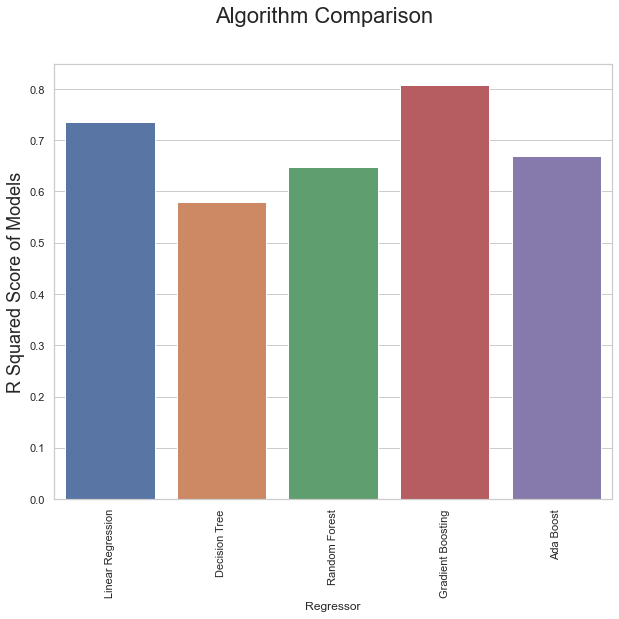

In [375]:
#Plot the performance of the model

fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.barplot(x=evaluationtable.index, y=evaluationtable['R-squared'])
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

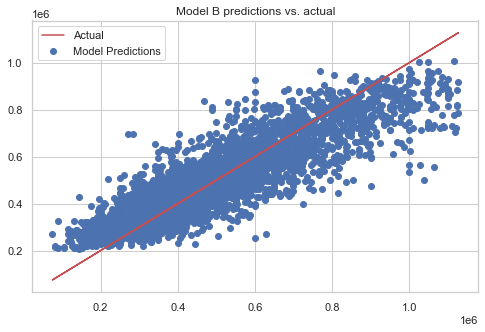

In [376]:
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_val, prediction, label='Model Predictions')
plt.plot(y_val, y_val, label='Actual', color='r')
plt.title('Model B predictions vs. actual')
plt.legend()
plt.show()

# Testing

In [383]:
#Best model is Random Forest
testing = GradientBoostingRegressor(learning_rate = 0.1 , max_depth = 3 , n_estimators = 1200)
testing.fit(X_train1,y_train1)
prediction = testing.predict(X_test)
Testing_table = pd.DataFrame({'Regressor':[],'Testing Score':[]
                                ,'R-squared':[],
                                'MSE':[],
                                'RMSE': []})

x1 = round(testing.score(X_test, y_test) , 3)
x2 = round(r2_score(prediction, y_test) , 3)
x3 = round(mean_squared_error(prediction, y_test) , 3)
x4 = round(np.sqrt(mean_squared_error(prediction, y_test)) , 3)
new_row = {'Regressor': 'Gradient Boosting' , 'Testing Score':x1, 'R-squared':x2, 'MSE':x3,'RMSE':x4}
Testing_table = Testing_table.append(new_row, ignore_index=True)

In [384]:
Testing_table

,Regressor,Testing Score,R-squared,MSE,RMSE
0,Gradient Boosting,0.834,0.799,6.933691e+09,83268.788


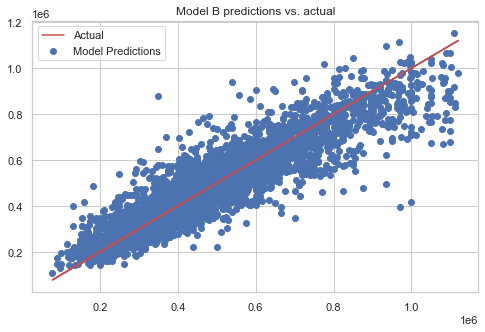

In [385]:
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_test, prediction, label='Model Predictions')
plt.plot(y_test, y_test, label='Actual', color='r')
plt.title('Model B predictions vs. actual')
plt.legend()
plt.show()

# Insights and Recommendations

* Waterfront living is key, with the median house price for a house with a waterfront view being almost double that of one that does not have this feature.
* following neighbourhoods: Medina, Clyde Hill and Bellevue (the most expensive neighbourhoods).
* Location within King County is important with a noticeable disparity amongst zipcodes.
* House prices do not appear to be affected by sale month or quarter, with the median house price being almost constant throughout the year.
* April and May are the most popular months for sales. In contrast, January and February have the lowest sales. Q2 alone accounts for 31.3% of sales.